In [63]:
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff

eeg_data_1 = pd.read_csv('data/subject7/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject7/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject7/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject7/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject7/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject7/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [64]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

### z-normalization

In [65]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [66]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [67]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

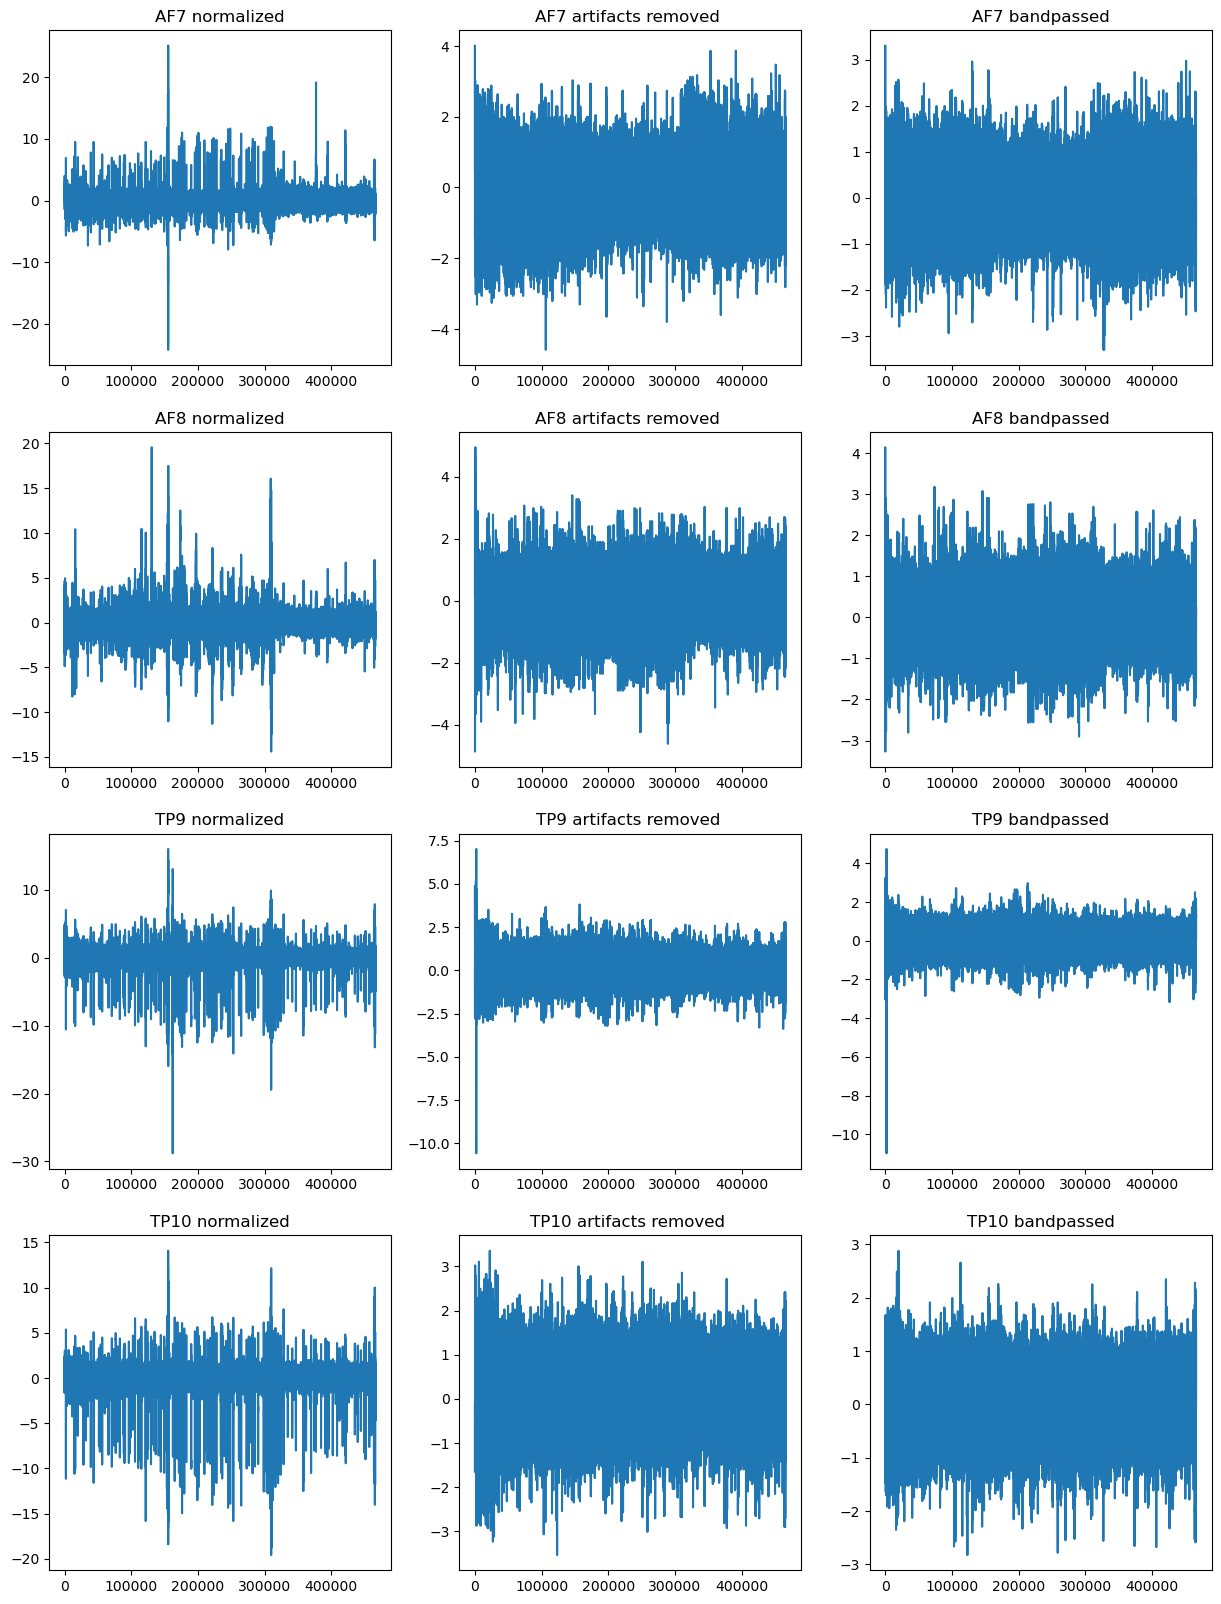

In [68]:
plot_preprocessing(channels=channels, eeg_df=eeg_data)

### Separate trials

In [69]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

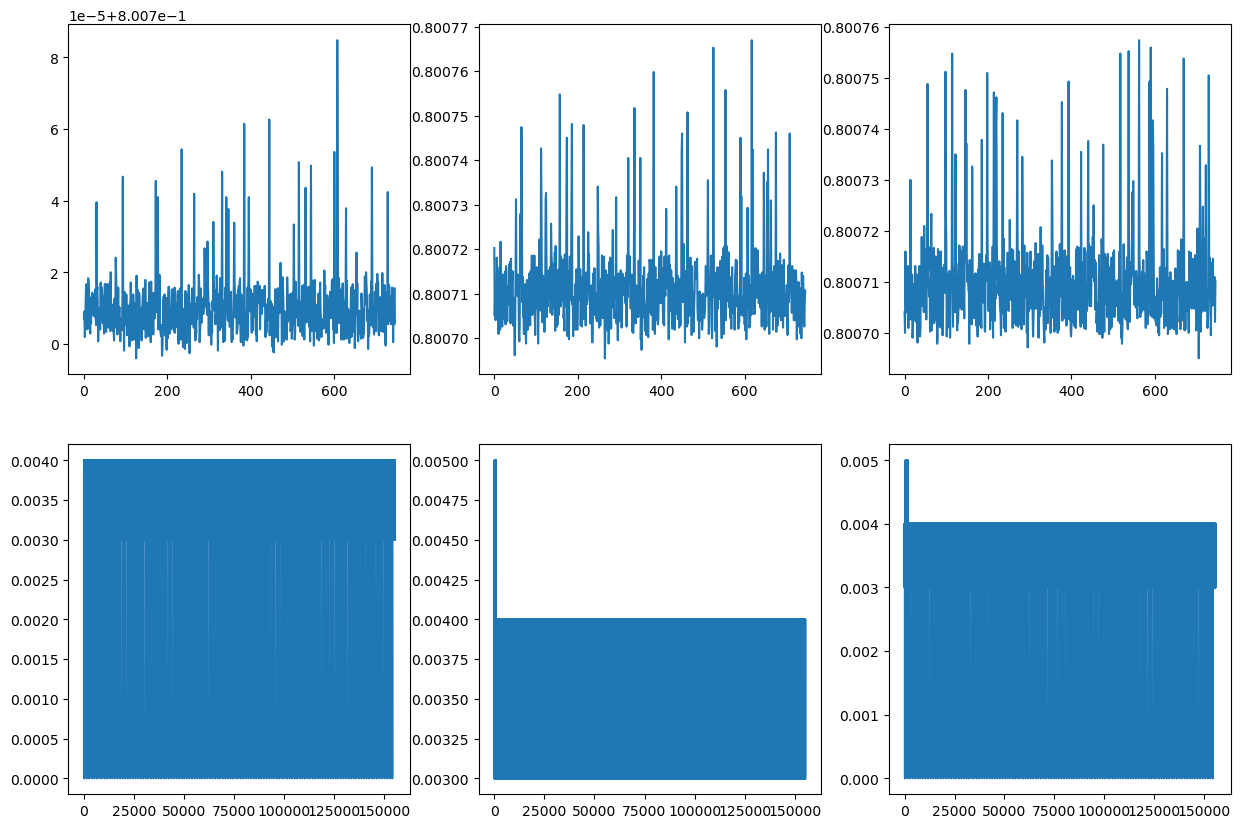

In [70]:
eeg_trials = [eeg_data_t1, eeg_data_t2, eeg_data_t3]
gradcpt_trials = [gradcpt_data_t1, gradcpt_data_t2, gradcpt_data_t3]
plot_sample_durations(eeg_trials, gradcpt_trials)

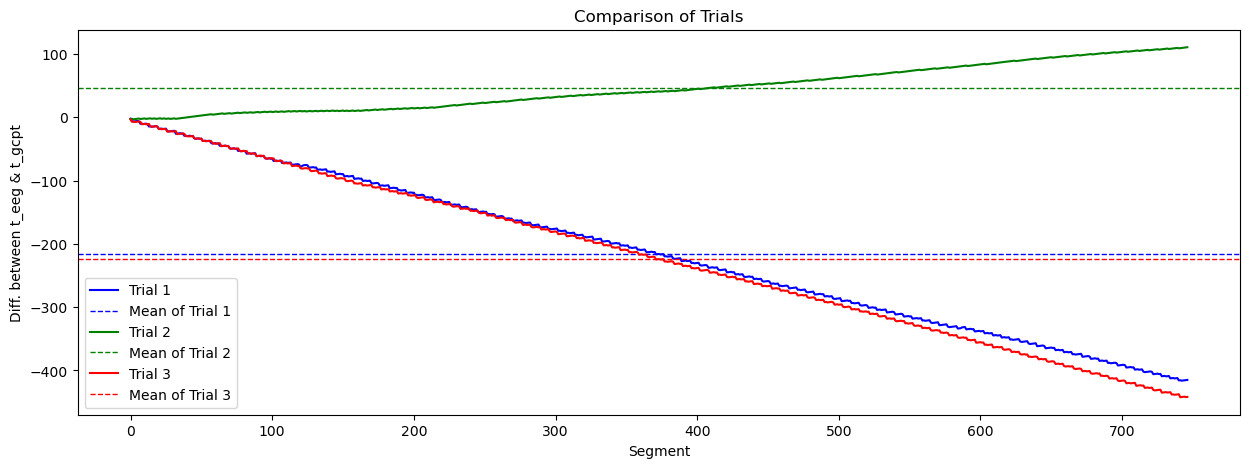

In [71]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### Segment

In [77]:
combined_eeg_df = pd.concat([eeg_data_t1, eeg_data_t3], ignore_index=True)
combined_gradcpt_df = pd.concat([gradcpt_data_t1, gradcpt_data_t3], ignore_index=True)

In [78]:
all_channel_segments = []

# Process each channel
for channel in channels:
    # Segment the current EEG data for the channel
    channel_segments = segment_column(combined_eeg_df[f'{channel}_bandpassed'], combined_gradcpt_df)
    
    # Convert the list of segments into a numpy array with shape (number of segments, 205)
    # Notice we're not introducing the singleton dimension this time
    channel_segments_array = np.array(channel_segments).reshape(-1, 205)
    
    # Append the reshaped segments for this channel to the list
    all_channel_segments.append(channel_segments_array)

# Stack the channel segments along a new axis to combine them
# This should result in a shape: (number of segments, number of channels, 205)
combined_segments = np.stack(all_channel_segments, axis=1)
labels = np.array(combined_gradcpt_df['in_the_zone'])

# Now the shape should be (743, 4, 205) for 743 segments, 4 channels, and 205 time points per segment
print(f"Corrected combined segments shape: {combined_segments.shape}")
print(f"Labels shape: {labels.shape}")

Corrected combined segments shape: (1494, 4, 205)
Labels shape: (1494,)


## Detach rocket

### Train and eval

In [97]:
from detach_rocket.detach_rocket.detach_classes import DetachRocket
from sklearn.model_selection import train_test_split

X = combined_segments
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = DetachRocket(model_type='minirocket', num_kernels=10000)
model.fit(X_train, y_train)

#Evaluate Performance on Test Set
detach_test_score, full_test_score= model.score(X_test,y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach-ROCKET: {:.2f}%'.format(100*detach_test_score))

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 73.60%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 85.00
Train Accuraccy Detach Model: 69.74%
-------------------------
Test Accuraccy Full Model: 58.22%
Test Accuraccy Detach-ROCKET: 54.67%


### Plot SFD Curve and Optimal Model selection

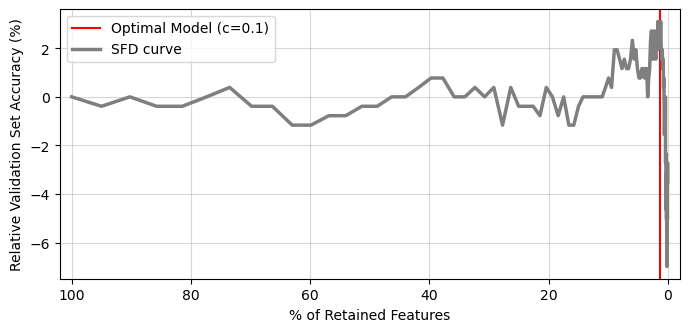

Optimal Model Size: 1.27% of full model


In [98]:
import matplotlib.pyplot as plt
percentage_vector = model._percentage_vector
acc_curve = model._sfd_curve

c = model.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100
point_x = x[model._max_index]
#point_y = y[model._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

In [99]:
X_transformed = model.transform_features(X)
y = labels

In [102]:
from sklearn.linear_model import (RidgeClassifierCV,RidgeClassifier)

X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

# CV to find best alpha
cv_classifier = RidgeClassifierCV(alphas=np.logspace(-10, 10, 20))
cv_classifier.fit(X_train, y_train)
model_alpha = cv_classifier.alpha_

# Refit with all training set
optimal_classifier = RidgeClassifier(alpha=model_alpha)
optimal_classifier.fit(X_train, y_train)
optimal_acc_train = optimal_classifier.score(X_train, y_train)

print(optimal_acc_train)

print(optimal_classifier.score(X_val, y_val))

0.6527196652719666
0.6220735785953178
